In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import joblib
from dotenv import load_dotenv
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [3]:
url = 'https://raw.githubusercontent.com/Projetos-III-UFPA-2024-4/engenheiros-do-acaii/refs/heads/main/backend/servicos/previsao-producao/dados/1a15MarcoEdgar.csv'
data = pd.read_csv(url, sep=',')
data.head()

,Tempo,Energia solar（kW）,Clima,Feed-in（kW）,Compra（kW）
0,2025/03/01 01:05:06,NaN,Nublado,NaN,NaN
1,2025/03/01 04:05:06,NaN,Ensolarado,NaN,NaN
2,2025/03/01 06:25:00,0.0,NaN,NaN,NaN
3,2025/03/01 06:30:00,0.0,NaN,NaN,NaN
4,2025/03/01 06:35:00,0.0,NaN,NaN,NaN


In [4]:
data['Tempo'] = pd.to_datetime(data['Tempo'])

In [5]:
# Preparando dados para Prophet
df = data.reset_index()[["Tempo", "Energia solar（kW）"]]
df.columns = ["ds", "y"]

In [6]:
df.tail()

,ds,y
2274,2025-03-15 18:10:00,0.07
2275,2025-03-15 18:15:00,0.05
2276,2025-03-15 18:20:00,0.02
2277,2025-03-15 19:05:06,NaN
2278,2025-03-15 22:05:06,NaN


### Tratamento da base de dados

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2279 entries, 0 to 2278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2279 non-null   datetime64[ns]
 1   y       2159 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.7 KB


In [8]:
df[df["y"].isnull()] 

,ds,y
0,2025-03-01 01:05:06,NaN
1,2025-03-01 04:05:06,NaN
11,2025-03-01 07:05:06,NaN
48,2025-03-01 10:05:06,NaN
85,2025-03-01 13:05:06,NaN
...,...,...
2175,2025-03-15 10:05:06,NaN
2212,2025-03-15 13:05:06,NaN
2249,2025-03-15 16:05:06,NaN
2277,2025-03-15 19:05:06,NaN


In [9]:
df = df.dropna()

In [10]:
df.shape

(2159, 2)

### Treinando modelo

In [11]:
# 🔹 Criar o modelo Prophet e treinar
modelo = Prophet()
modelo.fit(df)

14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# 🔹 Fazer previsão para os próximos 30 dias
futuro = modelo.make_future_dataframe(periods=1440, freq="15T")
previsao = modelo.predict(futuro)

C:\Users\David Sousa\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


### Métricas de Avaliação

In [13]:
# 🔹 Juntar dados reais com as previsões
df_comparacao = df.merge(previsao[["ds", "yhat"]], on="ds", how="inner")

In [14]:
# 🔹 Calcular métricas de erro
mae = mean_absolute_error(df_comparacao["y"], df_comparacao["yhat"])
mse = mean_squared_error(df_comparacao["y"], df_comparacao["yhat"])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((df_comparacao["y"] - df_comparacao["yhat"]) / df_comparacao["y"])) * 100

In [15]:
# 🔹 Exibir resultados
print(f"\n🔹 Métricas de Avaliação do Modelo Prophet:")
print(f"📌 MAE  (Erro Absoluto Médio): {mae:.4f}")
print(f"📌 MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"📌 RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")


🔹 Métricas de Avaliação do Modelo Prophet:
📌 MAE  (Erro Absoluto Médio): 0.3899
📌 MSE  (Erro Quadrático Médio): 0.2658
📌 RMSE (Raiz do Erro Quadrático Médio): 0.5155


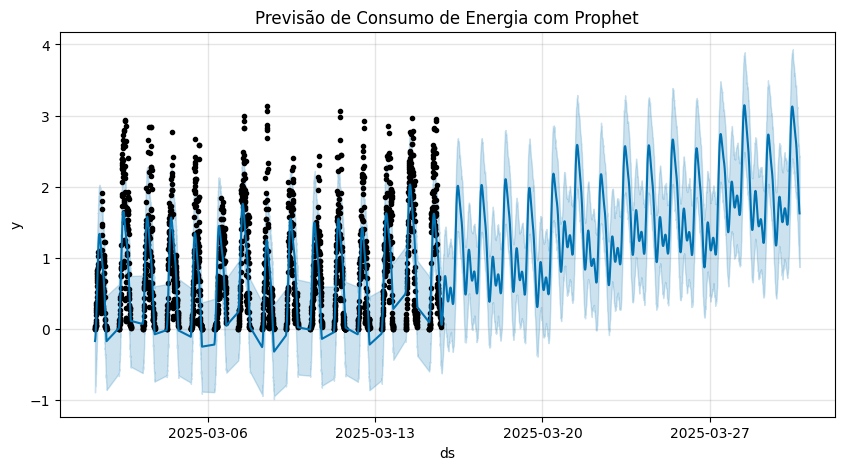

In [16]:
# 🔹 Plotar a previsão
fig, ax = plt.subplots(figsize=(10, 5))
modelo.plot(previsao, ax=ax)
plt.title("Previsão de Consumo de Energia com Prophet")
plt.show()

In [17]:
previsao.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3594,2025-03-30 17:20:00,2.046452,1.153148,2.573779,1.690206,2.414891,-0.176029,-0.176029,-0.176029,-0.331433,-0.331433,-0.331433,0.155404,0.155404,0.155404,0.0,0.0,0.0,1.870423
3595,2025-03-30 17:35:00,2.047282,1.030971,2.601757,1.690634,2.416401,-0.257111,-0.257111,-0.257111,-0.413330,-0.413330,-0.413330,0.156219,0.156219,0.156219,0.0,0.0,0.0,1.790171
3596,2025-03-30 17:50:00,2.048111,0.971501,2.482083,1.691061,2.417919,-0.327548,-0.327548,-0.327548,-0.484472,-0.484472,-0.484472,0.156924,0.156924,0.156924,0.0,0.0,0.0,1.720563
3597,2025-03-30 18:05:00,2.048941,0.896804,2.425134,1.691489,2.419301,-0.384420,-0.384420,-0.384420,-0.541940,-0.541940,-0.541940,0.157520,0.157520,0.157520,0.0,0.0,0.0,1.664521
3598,2025-03-30 18:20:00,2.049771,0.868533,2.433075,1.691917,2.420500,-0.425359,-0.425359,-0.425359,-0.583366,-0.583366,-0.583366,0.158006,0.158006,0.158006,0.0,0.0,0.0,1.624412


### Salvando em arquivo pkl

In [18]:
joblib.dump(modelo, "modelo_prophet.pkl")

['modelo_prophet.pkl']

### Salvando dados de previsão no Banco

In [19]:
previsao_data = previsao[['ds', 'yhat']]

In [20]:
previsao_data.rename(columns={"ds": "timestamp", "yhat": "geracao (kwh)"}, inplace=True)

C:\Users\David Sousa\AppData\Local\Temp\ipykernel_19700\2965436896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previsao_data.rename(columns={"ds": "timestamp", "yhat": "geracao (kwh)"}, inplace=True)


In [21]:
previsao_data

,timestamp,geracao (kwh)
0,2025-03-01 06:25:00,-0.170440
1,2025-03-01 06:30:00,-0.164718
2,2025-03-01 06:35:00,-0.156840
3,2025-03-01 06:40:00,-0.146766
4,2025-03-01 06:45:00,-0.134469
...,...,...
3594,2025-03-30 17:20:00,1.870423
3595,2025-03-30 17:35:00,1.790171
3596,2025-03-30 17:50:00,1.720563
3597,2025-03-30 18:05:00,1.664521


In [22]:
from sqlalchemy import create_engine
import pymysql

In [23]:
# 🔹 Carregar variáveis do .env
load_dotenv()

True

In [24]:
# 🔹 Configuração do Banco de Dados MySQL 
DB_USERNAME = os.getenv("DB_USERNAME")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DB_HOST = os.getenv("DB_HOST")
TABLE_NAME = "previsao_producao"

In [25]:
# 🔹 Criar conexão com o MySQL
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USERNAME,
    password=DB_PASSWORD,
    database=DB_NAME,
)
cursor = conn.cursor()

In [26]:
query = f"""
INSERT INTO {TABLE_NAME} (`geracao (kwh)`, `timestamp`)
VALUES (%s, %s)
"""

In [27]:
# 🔹 Inserir previsões no banco usando apenas `ds` e `yhat`, renomeados na query
for _, row in previsao_data.iterrows():
    cursor.execute(query, (row["geracao (kwh)"], row["timestamp"]))

# 🔹 Confirmar e fechar conexão
conn.commit()
cursor.close()
conn.close()

In [96]:
# 🔹 Criar conexão com MySQL
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USERNAME,
    password=DB_PASSWORD,
    database=DB_NAME
)
cursor = conn.cursor()

# 🔹 Query SQL para buscar as últimas 10 linhas inseridas
query = f"""
SELECT * FROM {TABLE_NAME}
ORDER BY timestamp DESC
LIMIT 10;
"""

# 🔹 Executar a consulta
cursor.execute(query)

# 🔹 Obter os resultados e armazenar em um DataFrame Pandas
colunas = [desc[0] for desc in cursor.description]  # Captura os nomes das colunas
resultados = cursor.fetchall()
df = pd.DataFrame(resultados, columns=colunas)  # Criar DataFrame com os resultados

# 🔹 Fechar conexão
cursor.close()
conn.close()

# 🔹 Mostrar os dados no terminal
print("\n🔹 Últimas 10 Previsões Inseridas no Banco:")
print(df)


🔹 Últimas 10 Previsões Inseridas no Banco:
     id  geracao (kwh)           timestamp
0  5760      -0.005721 2025-04-29 23:45:00
1  5759      -0.004697 2025-04-29 23:30:00
2  5758      -0.003108 2025-04-29 23:15:00
3  5757      -0.001120 2025-04-29 23:00:00
4  5756       0.001055 2025-04-29 22:45:00
5  5755       0.003178 2025-04-29 22:30:00
6  5754       0.005006 2025-04-29 22:15:00
7  5753       0.006311 2025-04-29 22:00:00
8  5752       0.006907 2025-04-29 21:45:00
9  5751       0.006670 2025-04-29 21:30:00
